In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import collections
import random

from typing import Any, Dict, List, Tuple, Union
from pathlib import Path

from recommend.utils import PROJ_ROOT

# Utility functions

In [2]:
def creators2list(creators : str, top_n_actors : int = 3) -> List[str]:
    """Returns a list of `top_n_actors`, director, and a composer."""
    result = []
    
    if 'Hrají' in creators:
        result = creators['Hrají'][:top_n_actors]
        result = list(map(lambda x: x[1], result))

    if 'Režie' in creators:
        result += [creators['Režie'][0][1]]
    if 'Hudba' in creators:
        result += [creators['Hudba'][0][1]]
    return result


def analyse_freq(list_of_lists : List[List[Any]]) -> List[Tuple[Any, int]]:
    """
    Counts occurences of items in a list of lists
    and returns them in descending order as tuples <item, count>."""

    flat_list = [item for sublist in list_of_lists for item in sublist]
    counter = collections.Counter(flat_list)
    return counter.most_common(len(counter))


def get_value(df : pd.DataFrame, movie_id : str, col : str) -> Any:
    """Retrieves a value in a cell specified by `col` for movie with ID `movie_id`"""
    return df.loc[df['movie_id'] == m_id][col].values[0]

def ids2df(ids : List[str], df : pd.DataFrame) -> pd.DataFrame:
    """Converts list of movie_ids to a dataframe while preserving order."""
    # faster but does not preserve order
    #mask = df['movie_id'].isin(ids)
    #return df.loc[mask]

    df_list = []
    for _id in ids:
        df_list.append(df[df['movie_id'] == _id])
    return pd.concat(df_list)

### Czech stemmer

In [3]:
#! /usr/bin/env python3.1
''' Czech stemmer
Copyright © 2010 Luís Gomes <luismsgomes@gmail.com>.

Ported from the Java implementation available at:
    http://members.unine.ch/jacques.savoy/clef/index.html

'''
import re
import sys



def cz_stem(word, aggressive=False):
    if not re.match("^\\w+$", word):
        return word
    if not word.islower() and not word.istitle() and not word.isupper():
        #print("warning: skipping word with mixed case: {}".format(word),
              #file=sys.stderr)
        return word
    s = word.lower() # all our pattern matching is done in lowercase
    s = _remove_case(s)
    s = _remove_possessives(s)
    if aggressive:
        s = _remove_comparative(s)
        s = _remove_diminutive(s)
        s = _remove_augmentative(s)
        s = _remove_derivational(s)
    if word.isupper():
        return s.upper()
    if word.istitle():
        return s.title()
    return s

def _remove_case(word):
    if len(word) > 7 and word.endswith("atech"):
        return word[:-5]
    if len(word) > 6:
        if word.endswith("ětem"):
            return _palatalise(word[:-3])
        if word.endswith("atům"):
            return word[:-4]
    if len(word) > 5:
        if word[-3:] in {"ech", "ich", "ích", "ého", "ěmi", "emi", "ému",
                         "ete", "eti", "iho", "ího", "ími", "imu"}:
            return _palatalise(word[:-2])
        if word[-3:] in {"ách", "ata", "aty", "ých", "ama", "ami",
                         "ové", "ovi", "ými"}:
            return word[:-3]
    if len(word) > 4:
        if word.endswith("em"):
            return _palatalise(word[:-1])
        if word[-2:] in {"es", "ém", "ím"}:
            return _palatalise(word[:-2])
        if word[-2:] in {"ům", "at", "ám", "os", "us", "ým", "mi", "ou"}:
            return word[:-2]
    if len(word) > 3:
        if word[-1] in "eiíě":
            return _palatalise(word)
        if word[-1] in "uyůaoáéý":
            return word[:-1]
    return word

def _remove_possessives(word):
    if len(word) > 5:
        if word[-2:] in {"ov", "ův"}:
            return word[:-2]
        if word.endswith("in"):
            return _palatalise(word[:-1])
    return word

def _remove_comparative(word):
    if len(word) > 5:
        if word[-3:] in {"ejš", "ějš"}:
            return _palatalise(word[:-2])
    return word

def _remove_diminutive(word):
    if len(word) > 7 and word.endswith("oušek"):
        return word[:-5]
    if len(word) > 6:
        if word[-4:] in {"eček", "éček", "iček", "íček", "enek", "ének",
                         "inek", "ínek"}:
            return _palatalise(word[:-3])
        if word[-4:] in {"áček", "aček", "oček", "uček", "anek", "onek",
                         "unek", "ánek"}:
            return _palatalise(word[:-4])
    if len(word) > 5:
        if word[-3:] in {"ečk", "éčk", "ičk", "íčk", "enk", "énk",
                         "ink", "ínk"}:
            return _palatalise(word[:-3])
        if word[-3:] in {"áčk", "ačk", "očk", "učk", "ank", "onk",
                         "unk", "átk", "ánk", "ušk"}:
            return word[:-3]
    if len(word) > 4:
        if word[-2:] in {"ek", "ék", "ík", "ik"}:
            return _palatalise(word[:-1])
        if word[-2:] in {"ák", "ak", "ok", "uk"}:
            return word[:-1]
    if len(word) > 3 and word[-1] == "k":
        return word[:-1]
    return word

def _remove_augmentative(word):
    if len(word) > 6 and word.endswith("ajzn"):
        return word[:-4]
    if len(word) > 5 and word[-3:] in {"izn", "isk"}:
        return _palatalise(word[:-2])
    if len(word) > 4 and word.endswith("ák"):
        return word[:-2]
    return word

def _remove_derivational(word):
    if len(word) > 8 and word.endswith("obinec"):
        return word[:-6]
    if len(word) > 7:
        if word.endswith("ionář"):
            return _palatalise(word[:-4])
        if word[-5:] in {"ovisk", "ovstv", "ovišt", "ovník"}:
            return word[:-5]
    if len(word) > 6:
        if word[-4:] in {"ásek", "loun", "nost", "teln", "ovec", "ovík",
                         "ovtv", "ovin", "štin"}:
            return word[:-4]
        if word[-4:] in {"enic", "inec", "itel"}:
            return _palatalise(word[:-3])
    if len(word) > 5:
        if word.endswith("árn"):
            return word[:-3]
        if word[-3:] in {"ěnk", "ián", "ist", "isk", "išt", "itb", "írn"}:
            return _palatalise(word[:-2])
        if word[-3:] in {"och", "ost", "ovn", "oun", "out", "ouš",
                         "ušk", "kyn", "čan", "kář", "néř", "ník",
                         "ctv", "stv"}:
            return word[:-3]
    if len(word) > 4:
        if word[-2:] in {"áč", "ač", "án", "an", "ář", "as"}:
            return word[:-2]
        if word[-2:] in {"ec", "en", "ěn", "éř", "íř", "ic", "in", "ín",
                         "it", "iv"}:
            return _palatalise(word[:-1])
        if word[-2:] in {"ob", "ot", "ov", "oň", "ul", "yn", "čk", "čn",
                         "dl", "nk", "tv", "tk", "vk"}:
            return word[:-2]
    if len(word) > 3 and word[-1] in "cčklnt":
        return word[:-1]
    return word

def _palatalise(word):
    if word[-2:] in {"ci", "ce", "či", "če"}:
        return word[:-2] + "k"

    if word[-2:] in {"zi", "ze", "ži", "že"}:
        return word[:-2] + "h"

    if word[-3:] in {"čtě", "čti", "čtí"}:
        return word[:-3] + "ck"

    if word[-3:] in {"ště", "šti", "ští"}:
        return word[:-3] + "sk"
    return word[:-1]

"""
if __name__ == '__main__':
    if len(sys.argv) != 2 or sys.argv[1] not in ("light", "aggressive"):
        sys.exit("usage: {} light|aggressive".format(sys.argv[0]))
    aggressive = sys.argv[1] == "aggressive"
    for line in sys.stdin:
        print(*[cz_stem(word, aggressive=aggressive)
                for word in line.split()])
"""
pass

# Load datasets

In [4]:
movies = pd.read_pickle(PROJ_ROOT / 'data' / 'movies.pkl')
ratings = pd.read_pickle(PROJ_ROOT / 'data' / 'ratings.pkl')

# Drop irrelevant columns
movies = movies.drop(columns=['kind', 'length', 'poster', 'foreign_titles'])

# Convert creators column to list of creators
movies['creators'] = movies['creators'].apply(creators2list)
#movies.reset_index(inplace=True) # causes trouble with join

display(movies.head(3))
ratings.head(3)

,title,description,genres,countries,year,creators
movie_id,,,,,,
230421-houbicky,Houbičky,"Partička amerických teenagerů, která si vyrazi...","[Horor, Thriller]","[Irsko, Velká Británie, Dánsko]",2007,"[Lindsey Haun, Jack Huston, Max Kasch, Paddy B..."
10789-prvni-liga,První liga,V nejvyšší lize získávají hráči baseballu boha...,"[Komedie, Sportovní]",[USA],1989,"[Tom Berenger, Charlie Sheen, Corbin Bernsen, ..."
235032-yes-man,Yes Man,"Carl Allen je zatrpklý bankovní úředník, který...","[Komedie, Romantický]",[USA],2008,"[Jim Carrey, Zooey Deschanel, Bradley Cooper, ..."


,username,movie_id,stars,date,comment
0,kinghome,230421-houbicky,5.0,2011-11-13,Hodnocení některých šašků tady opravdu necháp...
1,SimonShot,230421-houbicky,5.0,2012-12-19,Tento snímek je zajímavý už jenom tím že se n...
2,blackend,230421-houbicky,5.0,2010-09-04,Pohoda a vzhledem k dobré atmosféře a nízkému...


In [5]:
# get mean rating of each film 
avg_ratings = ratings[['movie_id', 'stars']].groupby(['movie_id']).mean()
avg_ratings.rename(columns={'stars': 'avg_stars'}, inplace=True)

# get rating count of each film
count_ratings = ratings[['movie_id', 'stars']].groupby('movie_id').count()
count_ratings.rename(columns={'stars': 'num_ratings'}, inplace=True)
count_ratings

# join with the movies database
movie_db = movies.join(avg_ratings).join(count_ratings).sort_values(by='num_ratings')
movie_db = movie_db.reset_index()
movie_db



# Compute Bayesian Average Rating Score -> 4.6* movie with many reviews > 5.0* movie with few reviews

def compute_bayes_avg(item_rating_avg : float, item_rating_count : int, M, C) -> float:
    """Computes Bayesian average rating for an item"""
    return (item_rating_avg * item_rating_count + C*M) / (item_rating_count + C)

# arithmetic average of all movies
M = np.sum(movie_db.avg_stars * movie_db.num_ratings) / np.sum(movie_db.num_ratings)     
# confidence number (~25% percentile)
C = movie_db.num_ratings.quantile(0.25)

movie_db['bayes_avg_rating'] = compute_bayes_avg(movie_db.avg_stars, movie_db.num_ratings, M, C)

movie_db

,movie_id,title,description,genres,countries,year,creators,avg_stars,num_ratings,bayes_avg_rating
0,75613-hercule-poirot_498504-serie-9,Hercule Poirot,Malý belgický detektiv Hercule Poirot (David S...,"[Krimi, Drama, Mysteriózní, Thriller]",[Velká Británie],(1989–2013),"[David Suchet, Hugh Fraser, Philip Jackson, Ed...",5.000000,1,3.501384
1,613789-obeti,Oběti,Na televizní obrazovku se vrací cyklus o lide...,[Drama],[Česko],(1999–2008),"[Zbyněk Fric, Karel Zima, Libor Žídek, Petr Sl...",5.000000,1,3.501384
2,75613-hercule-poirot_498507-serie-12,Hercule Poirot,Malý belgický detektiv Hercule Poirot (David S...,"[Krimi, Drama, Mysteriózní, Thriller]",[Velká Británie],(1989–2013),"[David Suchet, Hugh Fraser, Philip Jackson, Ed...",4.500000,2,3.506088
3,350930-krtek,Krtek,,"[Animovaný, Dobrodružný]","[Česko, Finsko]",2011,"[Zdeněk Miler, Wiliam Bukový]",4.500000,2,3.506088
4,33863-bajaja,Bajaja,Jiří Trnka natočil v roce 1950 volně podle poh...,"[Animovaný, Loutkový, Pohádka]",[Československo],1950,"[Jiří Trnka, Václav Trojan]",4.285714,14,3.581740
...,...,...,...,...,...,...,...,...,...,...
8669,232938-hobit-neocekavana-cesta,Hobit: Neočekávaná cesta,Film sleduje cestu hlavní postavy Bilbo Pytlík...,"[Dobrodružný, Fantasy]","[USA, Nový Zéland]",2012,"[Martin Freeman, Ian McKellen, Richard Armitag...",3.953150,3159,3.938292
8670,227786-interstellar,Interstellar,Příběh se odehrává v nepříliš vzdálené budoucn...,"[Sci-Fi, Dobrodružný, Drama]","[USA, Velká Británie, Kanada]",2014,"[Matthew McConaughey, Anne Hathaway, Jessica C...",4.072779,3174,4.054193
8671,223734-temny-rytir,Temný rytíř,Další Batmanovo dobrodružství začíná. Jeho pro...,"[Akční, Drama, Krimi, Thriller]","[USA, Velká Británie]",2008,"[Christian Bale, Heath Ledger, Aaron Eckhart, ...",4.559151,3770,4.530368
8672,254156-pocatek,Počátek,Dom Cobb (Leonardo DiCaprio) je velmi zkušený ...,"[Akční, Sci-Fi, Thriller, Mysteriózní, Dobrodr...","[USA, Velká Británie]",2010,"[Leonardo DiCaprio, Joseph Gordon-Levitt, Elli...",4.368000,4000,4.345674



# Recommendation Systems
---
## Base class

In [6]:
import abc

class RecSysBase(abc.ABC):
    """
    Recommendation System Base class.
    
    The system should store a database of available movies.
    
    """
    def __init__(self, movies_df : pd.DataFrame):
        self.movies_df = movies_df

    @abc.abstractmethod
    def recommend(self, user_history : List[str], n : int = None) -> pd.DataFrame:
        """
        Generates recommendations based on user's history of rated movies.
        
        Parameters
        ----------
        user_history : List[str]
            A list of movie ids a user has rated so far.
            
        n : int
            The number of recommendations to return.
            Default value None returns all movies from database.
        
        Returns
        -------
        pd.DataFrame
            movie_id ~ movie ID
            score_<class_name> ~ score of each movie
        """
        ...

    def get_candidate_movies(self, user_history : List[str]) -> pd.DataFrame:
        """Returns a list of candidates by filtering movies a user has already seen."""
        df = pd.concat([self.movies_df, self._ids2df(user_history, preserve_order=False)])
        # convert to str because drop_duplicates does not work on dfs containing structures
        return df.loc[df.astype(str).drop_duplicates(keep=False).index]

    def _ids2df(self, movie_ids : List[str], preserve_order : bool = True) -> pd.DataFrame:
        """For a list of movie ids returns a dataframe compatible with `self.movies_df`"""        
        if not preserve_order or len(movie_ids) == 0:
            # faster variant but sorted as in self.movies_df 
            mask = self.movies_df['movie_id'].isin(movie_ids)
            return self.movies_df.loc[mask]

        df_list = []
        for mid in movie_ids:
            df_list.append(self.movies_df[self.movies_df['movie_id'] == mid])
        return pd.concat(df_list)


## Random recommendations

In [7]:
import random

class RandomRS(RecSysBase):
    """
    System that recommends movies randomly.
    """
    def __init__(self, movies_df : pd.DataFrame):
        super(RandomRS, self).__init__(movies_df)

    def recommend(self, user_history : List[str], n : int = None) -> pd.DataFrame:
        """
        Recommends n random movies.
        Movies from `user_history` do not appear in the recommendations.
        """
        candidates = self.get_candidate_movies(user_history)
        recommendations = candidates.sample(n) if type(n) is int else candidates.sample(frac=1)
        recommendations = recommendations[['movie_id']]
        recommendations[f'score_{type(self).__name__}'] = 0 #np.linspace(start=1, stop=0, num=len(recommendations))
        return recommendations
    


In [8]:
rnd_rs = RandomRS(movie_db)

rnd_rs.recommend([])

,movie_id,score_RandomRS
1021,5567-hrbitov-domacich-zviratek-2,0
5923,272262-moje-krasna-ucitelka,0
7467,52430-nocni-zvirata,0
6909,246076-baader-meinhof-komplex,0
2014,305327-pravdivy-pribeh,0
...,...,...
6147,14121-junior,0
1989,15799-k-9-muj-pritel-se-studenym-cumakem,0
4737,182284-slecna-drsnak-2-jeste-drsnejsi,0
24,792-lizino-stesti,0


## Recommendation based on movie popularity

In [9]:

class TopNRS(RecSysBase):
    """
    System recommends top n most popular movies a user has not rated yet.
    """
    @abc.abstractmethod
    def __init__(self, movies_df : pd.DataFrame):#, by_column : str):
        super(TopNRS, self).__init__(movies_df)
        #self.by_column = by_column
        
    '''
    def set_by_column(self, new_column_name : str):
        """Changes the column which is used as a metric to sort the movies"""
        if new_column_name not in self.movies_df:
            raise AttributeError(f'Cannot use {new_column_name} to sort movies. Such column does not exist in the data frame.')
        self.by_column = new_column_name
    '''

    # abstract because subclasses need to define self.by_column
    def recommend(self, user_history : List[str], n : int = None) -> pd.DataFrame:
        """
        Recommends top n movies (a user has not yet seen) which are sorted by a selected column.
        """
        recommendations = self.get_candidate_movies(user_history)\
                                .sort_values(by=self.sort_by_column, ascending=False)\
                                .head(n)
        results = recommendations[['movie_id']].copy()
        results[f'score_{type(self).__name__}_{self.sort_by_column}'] = recommendations[self.sort_by_column]
        return results

    
class MostRatingsRS(TopNRS):
    def __init__(self, movies_df : pd.DataFrame):
        super(MostRatingsRS, self).__init__(movies_df)
        self.sort_by_column = 'num_ratings'
    
class TopBayesAvgRatingRS(TopNRS):
    def __init__(self, movies_df : pd.DataFrame):
        super(TopBayesAvgRatingRS, self).__init__(movies_df)
        self.sort_by_column = 'bayes_avg_rating'


In [10]:
history = ['228329-avatar']

rs_num_ratings = MostRatingsRS(movie_db)
rs_num_ratings.recommend(history)

,movie_id,score_MostRatingsRS_num_ratings
8672,254156-pocatek,4000
8671,223734-temny-rytir,3770
8670,227786-interstellar,3174
8669,232938-hobit-neocekavana-cesta,3159
8668,294824-nespoutany-django,3129
...,...,...
4,33863-bajaja,14
2,75613-hercule-poirot_498507-serie-12,2
3,350930-krtek,2
1,613789-obeti,1


In [11]:
rs_bayes_avg = TopBayesAvgRatingRS(movie_db)
rs_bayes_avg.recommend([])

,movie_id,score_TopBayesAvgRatingRS_bayes_avg_rating
8667,2294-vykoupeni-z-veznice-shawshank,4.724851
8466,821-s-certy-nejsou-zerty,4.710589
8595,1248-terminator-2-den-zuctovani,4.706829
8663,10135-forrest-gump,4.690586
8546,6178-dvanact-rozhnevanych-muzu,4.689629
...,...,...
7059,8597-jak-ukrast-dagmaru,0.949324
7746,289279-tisic-a-jedna-noc,0.895201
6759,226809-velmi-krehke-vztahy,0.857553
8339,215294-ordinace-v-ruzove-zahrade,0.829809


# Gensim models: TFIDF, LSI

In [12]:

class GensimModelWrapper(RecSysBase):
    """
    Base class for gensim based models.
    Implements methods for document preprocessing.
    """
    def __init__(self, movies_df : pd.DataFrame):
        super(GensimModelWrapper, self).__init__(movies_df)
    
    @abc.abstractmethod
    def recommend(self, user_history : List[str], n : int = None) -> pd.DataFrame:
        ...
    
    @classmethod
    def _document_to_tokens(cls, document: str) -> List[str]:
        """
        Filters stop words and applies stemming on the given string.

        Parameters
        ----------
        text : str
            A simple string containing text to preprocess.
        """
        tokens = word_tokenize(document.lower(), language='czech')
        tokens = [w.strip(",.:'?!()[]{}<>_-") for w in tokens]
        tokens = [w for w in tokens if w not in set(stop_words.get_stop_words('czech'))]
        tokens = [cz_stem(word) for word in tokens]
        tokens = [w for w in tokens if len(w) > 2]
        return tokens
    
    @classmethod
    def _document_to_bag_of_words(cls, document: str) -> List[Tuple[int, int]]:
        return cls.DICTIONARY.doc2bow(cls._document_to_tokens(document))
    
    @classmethod
    def _tokens_to_bag_of_words(cls, tokens: List[str]) -> List[Tuple[int, int]]:
        return cls.DICTIONARY.doc2bow(tokens)
    

## TF-IDF Base Model

In [13]:
import stop_words
from nltk.tokenize import word_tokenize
from multiprocessing import get_context, Pool
from gensim.corpora import Dictionary
from gensim.matutils import cossim
from gensim.models import TfidfModel
from gensim.similarities import SparseMatrixSimilarity
from gensim.utils import simple_preprocess
from tqdm import tqdm


class TfidfBaseRS(GensimModelWrapper):
    """
    TODO: finish & describewhat to do with subclasses: System recommends unseen movies using TF-IDF 
    """
    def __init__(self, movies_df : pd.DataFrame):
        super(TfidfBaseRS, self).__init__(movies_df)
        
        # TfidfRS subclasses need to implement what a document is
        documents = self.extract_documents(movies_df)
        
        #TODO: can we move the following functionality to GensimModelWrapper??
        # Build Dictionary
        with get_context('fork').Pool(None) as pool:
            doc_tokens = pool.imap(self.__class__._document_to_tokens, documents)
            doc_tokens = tqdm(doc_tokens, desc='Building the dictionary', total=len(documents))
            self.dictionary = Dictionary(doc_tokens)
            self.__class__.DICTIONARY = self.dictionary
        
        # Build TF-IDF model
        with get_context('fork').Pool(None) as pool:
            doc_bows = pool.imap(self.__class__._document_to_bag_of_words, documents)
            doc_bows = tqdm(doc_bows, desc='Building the TF-IDF model', total=len(documents))
            self.tfidf_model = TfidfModel(doc_bows)
            self.__class__.TFIDF_MODEL = self.tfidf_model

        # Build the index
        with get_context('fork').Pool(None) as pool:    
            doc_vectors = pool.imap(self.__class__._document_to_tfidf_vector, documents)
            doc_vectors = tqdm(doc_vectors, desc='Building the TF-IDF index', total=len(documents))
            self.index = SparseMatrixSimilarity(doc_vectors, num_docs=len(documents), num_terms=len(self.dictionary))
            
        del self.__class__.DICTIONARY
        del self.__class__.TFIDF_MODEL 

        self.index_to_movie_id = dict(enumerate(self.movies_df.movie_id.to_list()))

    @abc.abstractstaticmethod
    def extract_documents(movies_df : pd.DataFrame) -> List[str]:
        """Method extracts list of documents from movie_db"""
        ...
    
    def get_document_for_movie_id(self, movie_id : str) -> str:
        """Returns a document for movie with provided ID"""
        return self.extract_documents(self.movies_df.loc[self.movies_df['movie_id'] == movie_id])[0]
    
    """
    # TODO: basically only used to cteate the query
    def get_description_with_id(self, movie_id : str) -> str:
        '''Returns a document for movie with provided ID'''
        #TODO: get rid of or put it into a baseclass
        #TODO: handle case when no such movie exists
        return self.movies_df.loc[self.movies_df['movie_id'] == movie_id].description.values[0]
    """
    
    def recommend(self, user_history : List[str], n : int = None) -> pd.DataFrame:
        """Recommends unseen movies using tfidf vectors and cosine similarity.
        
        Parameters
        ----------
        user_history : List[str]
            A list of movie IDs
        
        n : int
            Recommends n movies, if set to an integer.
            Default value None returns all the movies.
        """
        # Take last k movies, join them into a single description and create a query.
        k = 50 # TODO: should this be a configurable parameter? should it be tuned?
        last_k_movies = user_history[-k:]
        query = ' '.join([self.get_document_for_movie_id(mid) for mid in last_k_movies])
        
        self.__class__.DICTIONARY = self.dictionary
        self.__class__.TFIDF_MODEL = self.tfidf_model

        query_vector = self.__class__._document_to_tfidf_vector(query)
        similarities = enumerate(self.index[query_vector])
        similarities = sorted(similarities, key=lambda item: item[1], reverse=True)

        result_ids, scores = [], []
        for idx, sim in similarities:
            movie_id = self.index_to_movie_id[idx]
            if movie_id not in user_history:
                result_ids.append(movie_id)
                scores.append(sim)
            
            if len(result_ids) == n:
                break
        
        del self.__class__.DICTIONARY
        del self.__class__.TFIDF_MODEL
        
        return pd.DataFrame({
            'movie_id': result_ids,
            f'score_{type(self).__name__}': scores
        })

    @classmethod
    def _document_to_tfidf_vector(cls, document: str) -> List[Tuple[int, float]]:
        return cls.TFIDF_MODEL[cls._document_to_bag_of_words(document)]
    
    @classmethod
    def _bow_to_tfidf_vector(cls, bow: List[Tuple[int, int]]) -> List[Tuple[int, float]]:
        return cls.TFIDF_MODEL[bow]

    

## TF-IDF recommender systems

In [14]:
class TfidfTitleRS(TfidfBaseRS):
    def __init__(self, movies_df : pd.DataFrame):
        super(TfidfTitleRS, self).__init__(movies_df)

    @staticmethod
    def extract_documents(movies_df : pd.DataFrame) -> List[str]:
        """Method extracts list of documents from movie_db"""
        return list(movies_df.title.astype(str))

    
class TfidfDescriptionTitleRS(TfidfBaseRS):
    def __init__(self, movies_df : pd.DataFrame):
        super(TfidfDescriptionTitleRS, self).__init__(movies_df)

    @staticmethod
    def extract_documents(movies_df : pd.DataFrame) -> List[str]:
        """Method extracts list of documents from movie_db"""
        return list(movies_df.title.astype(str) + ' ' + movies_df.description)


class TfidfGenresRS(TfidfBaseRS):
    # TODO: inverse frequency does not work well the way I use it atm.
    # If user sees many Action movies and a single Animated movie then he is presented with tons of Animated movies :}
    # Maybe change how query is created or play with 
    def __init__(self, movies_df : pd.DataFrame):
        super(TfidfGenresRS, self).__init__(movies_df)

    @staticmethod
    def extract_documents(movies_df : pd.DataFrame) -> List[str]:
        """Method extracts list of documents from movie_db"""
        return [' '.join(genre_list) for genre_list in movies_df.genres]


    @classmethod
    def _document_to_tokens(cls, document: str) -> List[str]:
        """
        Filters stop words and applies stemming on the given string.

        Parameters
        ----------
        text : str
            A simple string containing text to preprocess.
        """
        return word_tokenize(document.lower(), language='czech')

In [15]:
rs_tfidf_descr_title = TfidfDescriptionTitleRS(movie_db)

Building the TF-IDF index: 100%|████████████████████████████████████████████████████████████| 8674/8674 [00:08<00:00, 1017.32it/s]


In [16]:
history = ['1644-kmotr', '1645-kmotr-ii', '9499-matrix', '342231-lego-batman']
rs_tfidf_descr_title.recommend(history, n=15)

,movie_id,score_TfidfDescriptionTitleRS
0,1646-kmotr-iii,0.312191
1,1643-kmotr-1-2-3,0.273426
2,392898-lego-r-batman-film,0.167242
3,6-maffiosso,0.153228
4,9498-matrix-revolutions,0.152167
5,266796-liga-spravedlivych-krize-na-dvou-zemich,0.141337
6,223734-temny-rytir,0.134347
7,1069-batman,0.131433
8,319515-batman-navrat-temneho-rytire-cast-2,0.123253
9,60899-batman-vs-joker,0.121176


---
### TFIDF on genres

In [17]:
rs_tfidf_genres = TfidfGenresRS(movie_db)

Building the TF-IDF index: 100%|████████████████████████████████████████████████████████████| 8674/8674 [00:01<00:00, 8573.03it/s]


In [18]:
history = ['1644-kmotr', '1645-kmotr-ii', '9499-matrix', '342231-lego-batman']
rs_tfidf_genres.recommend(history)

,movie_id,score_TfidfGenresRS
0,90518-kovboj-bebop-lovec-odmen,0.867701
1,194929-temny-obraz,0.866236
2,12110-zelezny-obr,0.809641
3,288161-batman-rok-jedna,0.789442
4,71858-ochrance,0.786381
...,...,...
8665,292988-meda,0.000000
8666,249773-parba-ve-vegas,0.000000
8667,68928-pratele,0.000000
8668,234260-teorie-velkeho-tresku,0.000000


### TFIDF on titles only


In [19]:
rs_tfidf_titles = TfidfTitleRS(movie_db)

Building the TF-IDF index: 100%|████████████████████████████████████████████████████████████| 8674/8674 [00:01<00:00, 8374.79it/s]


In [20]:
history = ['1644-kmotr', '1645-kmotr-ii', '9499-matrix', '342231-lego-batman']
rs_tfidf_titles.recommend(history, 15)

,movie_id,score_TfidfTitleRS
0,1643-kmotr-1-2-3,0.722059
1,308348-pribeh-kmotra,0.590029
2,1646-kmotr-iii,0.553994
3,93895-batman,0.299027
4,1069-batman,0.299027
5,9498-matrix-revolutions,0.254653
6,9497-matrix-reloaded,0.254653
7,366712-the-den,0.218506
8,288161-batman-rok-jedna,0.210468
9,351124-batmanuv-syn,0.204622


## LSA Model

https://www.datacamp.com/community/tutorials/discovering-hidden-topics-python

In [21]:
from gensim.models import LsiModel

# TODO: just copied, not working yet
class LsiRS(GensimModelWrapper):
    def __init__(self, movies_df : pd.DataFrame):
        super(LsiRS, self).__init__(movies_df)
        
        # Document == movie title & description
        documents = list(movies_df.title.astype(str) + ' ' + movies_df.description)
        
        # Build Dictionary
        with get_context('fork').Pool(None) as pool:
            doc_tokens = pool.imap(self.__class__._document_to_tokens, documents)
            doc_tokens = tqdm(doc_tokens, desc='Building the dictionary', total=len(documents))
            self.dictionary = Dictionary(doc_tokens)
            self.__class__.DICTIONARY = self.dictionary
        
        # Build TF-IDF model
        with get_context('fork').Pool(None) as pool:
            #doc_bows = pool.imap(self.__class__._tokens_to_bag_of_words, self.__class__.doc_tokens)
            doc_bows = pool.imap(self.__class__._document_to_bag_of_words, documents)
            doc_bows = tqdm(doc_bows, desc='Building the TF-IDF model', total=len(documents))
            self.lsi_model = LsiModel(doc_bows)
            self.__class__.LSI_MODEL = self.lsi_model

        # Build the index
        with get_context('fork').Pool(None) as pool:    
            #doc_vectors = pool.imap(self.__class__._bow_to_tfidf_vector, self.doc_bows)
            doc_vectors = pool.imap(self.__class__._document_to_tfidf_vector, documents)
            doc_vectors = tqdm(doc_vectors, desc='Building the TF-IDF index', total=len(documents))
            self.index = SparseMatrixSimilarity(doc_vectors, num_docs=len(documents), num_terms=len(self.dictionary))
            
        del self.__class__.DICTIONARY
        del self.__class__.TFIDF_MODEL 

        self.index_to_movie_id = dict(enumerate(self.movies_df.movie_id.to_list()))

    
    def recommend(self, user_history : List[str], n : int = 10, return_df : bool = False) -> List[str]:
        # TODO:
        ...

    @classmethod
    def _document_to_lsi_vector(cls, document: str) -> List[Tuple[int, float]]:
        return cls.LSI_MODEL[cls._document_to_bag_of_words(document)]
    
    @classmethod
    def _bow_to_lsi_vector(cls, bow: List[Tuple[int, int]]) -> List[Tuple[int, float]]:
        return cls.LSI_MODEL[bow]

In [210]:
# Build a Dictionary
documents = movie_db.description.to_list()
doc_tokens = list(map(GensimModelWrapper._document_to_tokens, documents))
#doc_tokens = tqdm(doc_tokens, desc='Building the dictionary', total=len(documents))
dictionary = Dictionary(doc_tokens)

In [211]:
def tokens2bow(dct, tokens):
    return dct.doc2bow(tokens)

corpus_bows = [tokens2bow(dictionary, tokens) for tokens in doc_tokens]
#corpus_bows = tqdm(corpus_bows, desc='Building LSI model', total=len(documents))
lsi_model = LsiModel(corpus_bows, num_topics=200, id2word=dictionary)

In [212]:
lsi_model

---
# Ensembles

In [22]:
from sklearn.preprocessing import MinMaxScaler

class Ensemble:
    """
    Class representing an ensemble of algorithms that individually give scores to movies.
    The final recommendation is made by combining the scores and taking the top n movies.
    
    Parameters
    ----------
    movies_df : pd.DataFrame
        Movie database that is provided to each RecSys based class.

    rs_classes : List[RecSysBase]
        List containing subclasses of RecSysBase to use in the ensemble.

    rs_weights : List[float]
        A list of floats that is used to weight the importance of used algorithms.
        The list should sum to 1 and the order needs to match the order in `rs_classes`.
        By default all the columns have the same weight.
    """
    def __init__(self, movies_df : pd.DataFrame, rs_classes: List[type[RecSysBase]], rs_weights: List[float] = None):
        self.movies_df = movies_df
        self.rs_weights = rs_weights
        self.recsystems = [RS(movies_df) for RS in rs_classes]
    
    def apply_algs(self, movie_ids : List[str], df_merge_how : str = 'inner') -> pd.DataFrame:
        """Returns scores given to movies by each recommendation algorithm.
        
        Parameters
        ----------
        movie_ids : List[str]
            List of movie_ids
        
        df_merge_how : str
            Argument for pd.DataFrame.merge method on how to perform the merge.
            Default is "inner".
        
        Returns
        -------
        pd.DataFrame
            For each `movie_id` there are columns with scores named `score_<name of a RS>`.
        """
        dataframes = [rs.recommend(movie_ids) for rs in self.recsystems]
        
        result_df = dataframes[0]
        
        for df in dataframes[1:]:
            # TODO: watch out for `how` when joining dfs without all movies present
            result_df = result_df.merge(df, how=df_merge_how, on='movie_id')
        
        return result_df

    def combine_scores(self, scores_table: pd.DataFrame, normalize : bool = True, rs_weights : List[float] = None) -> pd.DataFrame:
        """
        Combines recommendation scores of the available algorithms.
        
        Parameters
        ----------
        scores_table : pd.DataFrame
            A DataFrame containing at least `movie_id` and scores of the algs as `score_<name of the alg>`
        
        normalize : bool
            Wether to peform min max scaling of each column with score.
            Default is true.
            TODO: alternatively ignore scores and work simply with ranks?
        
        Returns
        -------
        pd.DataFrame
            The final score for each movie is stored in column `final_score`
        """
        
        score_cols = [c for c in scores_table.columns if c.startswith('score_')]
        
        if normalize:
            scaler = MinMaxScaler()
            scores_table[score_cols] = scaler.fit_transform(scores_table[score_cols])
        
        weights = rs_weights if self.rs_weights is None else self.rs_weights
        
        if weights is not None and len(weights) == len(score_cols):
            # NOTE: make sure that the order matches?
            print(f'Weighting the algorithms: {weights}')
            scores_table[score_cols] = scores_table[score_cols] * weights
        
        scores_table['final_score'] = scores_table[score_cols].sum(axis=1)
        return scores_table

    
    def recommend(self,
                  movie_ids: List[str],
                  n : int = None,
                  rs_weights : List[float] = None,
                  return_full_info=False) -> List[str]:
        """Produces a list of recommendations by combining results of its ensemble.
        
        Parameters
        ----------
        movie_ids : List[str]
            List of movie ids representing the user history.

        n : int
            Number of movies to recommend.
            Default value is None - all available movies are returned in desceding order by score.  
        
        rs_weights : List[float]
            A list of floats that is used to weight the importance of used algorithms.
            The list should sum to 1 and the order needs to match the order in `self.rs_classes`.
            By default all the columns have the same weight.
            Overrides self.rs_weights.
        """
        scores = self.apply_algs(movie_ids)
        # TODO: return only movie_ids? return movie_ids & final_scores? 
        recommendations = self.combine_scores(scores,
                                              normalize=True,
                                              rs_weights=rs_weights).sort_values(by='final_score', ascending=False)
        recommendations = recommendations if n is None else recommendations[:n]
        return recommendations if not return_full_info else recommendations.merge(self.movies_df, how='inner', on='movie_id')
        

    
    def userId_to_history(self, user_id : str) -> List[str]:
        # TODO: helper func. for testing purpose
        ...


In [64]:
ensemble = Ensemble(movie_db, [TopBayesAvgRatingRS, MostRatingsRS, TfidfTitleRS, TfidfDescriptionTitleRS])

Building the TF-IDF index: 100%|████████████████████████████████████████████████████████████| 8674/8674 [00:08<00:00, 1072.54it/s]


In [65]:
history

['1644-kmotr', '1645-kmotr-ii', '9499-matrix', '342231-lego-batman']

In [66]:
ensemble.recommend(history, n=15)

,movie_id,score_TopBayesAvgRatingRS_bayes_avg_rating,score_MostRatingsRS_num_ratings,score_TfidfTitleRS,score_TfidfDescriptionTitleRS,final_score
271,1646-kmotr-iii,0.870542,0.143663,0.767242,1.000000,2.781447
240,1643-kmotr-1-2-3,0.876873,0.026519,1.000000,0.875830,2.779222
23,223734-temny-rytir,0.951909,0.787012,0.000000,0.430337,2.169258
706,228329-avatar,0.820036,1.000000,0.000000,0.060627,1.880663
442,1069-batman,0.844674,0.171643,0.414131,0.421004,1.851452
118,254156-pocatek,0.906238,0.835039,0.000000,0.072225,1.813502
3275,308348-pribeh-kmotra,0.712402,0.137398,0.817149,0.115541,1.782490
303,252669-temny-rytir-povstal,0.865476,0.628941,0.000000,0.263657,1.758074
0,2294-vykoupeni-z-veznice-shawshank,1.000000,0.651493,0.000000,0.067825,1.719318
160,136224-batman-zacina,0.897306,0.352892,0.245835,0.221140,1.717173


In [69]:
ensemble.recommend(history, n=15, rs_weights=[0.25, 0.1, 0.25, 0.8], return_full_info=True)

Weighting the algorithms: [0.25, 0.1, 0.25, 0.8]


,movie_id,score_TopBayesAvgRatingRS_bayes_avg_rating,score_MostRatingsRS_num_ratings,score_TfidfTitleRS,score_TfidfDescriptionTitleRS,final_score,title,description,genres,countries,year,creators,avg_stars,num_ratings,bayes_avg_rating
0,1646-kmotr-iii,0.217636,0.014366,0.191811,0.800000,1.223812,Kmotr III,Člověk financí a politiky. Al Pacino v hlavní ...,"[Drama, Krimi]",[USA],1990,"[Al Pacino, Diane Keaton, Talia Shire, Francis...",4.309144,689,4.201318
1,1643-kmotr-1-2-3,0.219218,0.002652,0.250000,0.700664,1.172534,"Kmotr 1, 2, 3",Původní trilogie KMOTR je zde sestříhána v chr...,"[Krimi, Drama, Thriller]",[USA],1992,"[Marlon Brando, Al Pacino, Robert Duvall, Fran...",4.828125,128,4.226920
2,1069-batman,0.211168,0.017164,0.103533,0.336803,0.668668,Batman,"V Gothamu bojuje proti zločinu nejen policie, ...","[Akční, Krimi, Thriller]","[USA, Velká Británie]",1989,"[Michael Keaton, Jack Nicholson, Kim Basinger,...",4.173755,823,4.096705
3,392898-lego-r-batman-film,0.175894,0.006724,0.056167,0.428564,0.667349,LEGO® Batman film,Batman pokračuje v neúnavné obraně Gotham City...,"[Animovaný, Akční, Dobrodružný, Komedie, Rodin...","[USA, Dánsko]",2017,"[Will Arnett, Jenny Slate, Ralph Fiennes, Chri...",3.538700,323,3.526102
4,9498-matrix-revolutions,0.170655,0.018229,0.088169,0.389934,0.666987,Matrix Revolutions,Ve výbušné závěrečné kapitole trilogie Matrix ...,"[Akční, Sci-Fi]","[USA, Austrálie]",2003,"[Keanu Reeves, Laurence Fishburne, Carrie-Anne...",3.435927,874,3.441355
5,223734-temny-rytir,0.237977,0.078701,0.000000,0.344270,0.660948,Temný rytíř,Další Batmanovo dobrodružství začíná. Jeho pro...,"[Akční, Drama, Krimi, Thriller]","[USA, Velká Británie]",2008,"[Christian Bale, Heath Ledger, Aaron Eckhart, ...",4.559151,3770,4.530368
6,319515-batman-navrat-temneho-rytire-cast-2,0.211921,0.004260,0.047185,0.315840,0.579206,"Batman: Návrat Temného rytíře, část 2.","Filmová adaptace komiksu ""Návrat Temného rytíř...","[Animovaný, Akční]",[USA],2013,"[Peter Weller, Ariel Winter, Michael McKean, J...",4.424390,205,4.108885
7,9497-matrix-reloaded,0.186074,0.019440,0.088169,0.271680,0.565363,Matrix Reloaded,Druhé pokračování trilogie nás opět zavede do...,"[Akční, Sci-Fi]","[USA, Austrálie]",2003,"[Keanu Reeves, Laurence Fishburne, Carrie-Anne...",3.713519,932,3.690777
8,6-maffiosso,0.167248,0.004114,0.000000,0.392652,0.564014,Maffiósso,Mistr filmové parodie Jim Abrahams si vzal ten...,"[Komedie, Drama, Krimi]",[USA],1998,"[Jay Mohr, Billy Burke, Christina Applegate, J...",3.333333,198,3.386243
9,274187-batman-vs-red-hood,0.200124,0.003759,0.053705,0.300289,0.557877,Batman vs. Red Hood,Tento akcí nabitý animovaný Batman staví proti...,"[Animovaný, Akční, Krimi, Thriller]",[USA],2010,"[Bruce Greenwood, Jason Isaacs, Neil Patrick H...",4.165746,181,3.918054


---

### Examples

a) recommendations for movie Rivals about F1 race drives:  
* solid recommendations almost all movies are about main characters competing / rivalry (in some form)
* bad recommendations:
    * 295103-domek-z-karet - does not fit at all
    * Rivalové (14623-rivalove) - is ranked as 1st because of the title match unless we weight down the TfidfTitleRS

In [73]:
rivals = '301401-rivalove'

sport_movies = [rivals]

ensemble.recommend(sport_movies, n=15, rs_weights=[0.25, 0.1, 0.25, 0.5], return_full_info=True)

Weighting the algorithms: [0.25, 0.1, 0.25, 0.5]


,movie_id,score_TopBayesAvgRatingRS_bayes_avg_rating,score_MostRatingsRS_num_ratings,score_TfidfTitleRS,score_TfidfDescriptionTitleRS,final_score,title,description,genres,countries,year,creators,avg_stars,num_ratings,bayes_avg_rating
0,138038-na-plny-plyn,0.147656,0.001316,0.00,0.473880,0.622852,Na plný plyn,"Rychlá závodní auta, rivalita, přátelství, lás...","[Akční, Sportovní]",[Francie],2003,"[Sagamore Stévenin, Peter Youngblood Hills, Je...",2.390625,64,3.069318
1,4159-formule,0.106022,0.006598,0.00,0.500000,0.612620,Formule!,Mladičký a mimořádně talentovaný závodník Jimm...,"[Akční, Drama, Sportovní]","[USA, Kanada, Austrálie]",2001,"[Sylvester Stallone, Kip Pardue, Til Schweiger...",2.037855,317,2.395832
2,291617-senna,0.230968,0.013113,0.00,0.339178,0.583259,Senna,Film SENNA přináší skutečný příběh legendárníh...,"[Dokumentární, Životopisný, Sportovní]","[Velká Británie, Francie]",2010,"[Ayrton Senna, Rubens Barrichello, Gerhard Ber...",4.570747,629,4.416979
3,240522-drive,0.203106,0.052537,0.00,0.291505,0.547149,Drive,Říkají mu Řidič. Přes den je filmovým kaskadér...,"[Krimi, Thriller, Drama]",[USA],2011,"[Ryan Gosling, Carey Mulligan, Bryan Cranston,...",3.986095,2517,3.966290
4,14623-rivalove,0.169477,0.004218,0.25,0.087101,0.510796,Rivalové,Titulní postava Happy Gilmore je dospívající m...,"[Komedie, Sportovní]",[USA],1996,"[Adam Sandler, Christopher McDonald, Julie Bow...",3.389163,203,3.422298
5,772-magicka-hlubina,0.210516,0.008144,0.00,0.271259,0.489919,Magická hlubina,Jean Reno a Jean-Marc Barr dva přátelé z dětst...,"[Drama, Romantický, Dobrodružný]","[Francie, USA, Itálie]",1988,"[Rosanna Arquette, Jean-Marc Barr, Jean Reno, ...",4.245524,391,4.086152
6,295103-domek-z-karet,0.225407,0.015536,0.00,0.244964,0.485906,Domek z karet,"Cesta do Bílého domu je dlážděna ambicemi, nez...",[Drama],[USA],(2013–2018),"[Kevin Spacey, Robin Wright, Michael Kelly, Da...",4.444295,745,4.327026
7,221097-extremni-svahy,0.177191,0.001420,0.00,0.306475,0.485087,Extrémní svahy,Pět nejlepších snowboardistů světa přijíždí na...,"[Dokumentární, Sportovní]",[USA],2005,"[Travis Rice, Terje Håkonsen, Shaun White, Kem...",3.637681,69,3.547083
8,230220-fighter,0.191136,0.020986,0.00,0.266905,0.479026,Fighter,Hvězdně obsazené biografické drama v hlavních...,"[Drama, Sportovní, Životopisný]",[USA],2010,"[Mark Wahlberg, Christian Bale, Amy Adams, Dav...",3.802187,1006,3.772653
9,2471-synove-hor,0.178456,0.001253,0.00,0.290013,0.469722,Synové hor,Příběh o přátelství na život a na smrt zachycu...,"[Drama, Životopisný, Sportovní]",[Československo],1956,"[Josef Bek, Svatava Hubeňáková, Jiří Vala, Čen...",3.704918,61,3.567548


In [107]:
display(movie_db[movie_db.title == 'Mlčení jehňátek'])

,movie_id,title,description,genres,countries,year,creators,avg_stars,num_ratings,bayes_avg_rating
8418,2356-mlceni-jehnatek,Mlčení jehňátek,Mladá citlivá agentka FBI Clarice Steriling je...,"[Thriller, Krimi, Horor, Drama]",[USA],1991,"[Jodie Foster, Anthony Hopkins, Scott Glenn, J...",4.530644,1289,4.452725


---
Movie `2777-svedska-trojka` is not a good recommendation

In [74]:
lion_king = '6741-lvi-kral'
madagaskar = '117282-madagaskar'
over_the_hedge = '43170-za-plotem'

disney_movies = [lion_king, madagaskar, over_the_hedge]

ensemble.recommend(disney_movies, n=15, rs_weights=[1,0.1,1,1], return_full_info=True)

Weighting the algorithms: [1, 0.1, 1, 1]


,movie_id,score_TopBayesAvgRatingRS_bayes_avg_rating,score_MostRatingsRS_num_ratings,score_TfidfTitleRS,score_TfidfDescriptionTitleRS,final_score,title,description,genres,countries,year,creators,avg_stars,num_ratings,bayes_avg_rating
0,516317-lvi-kral,0.730019,0.008582,1.000000,0.883475,2.622076,Lví král,"Snímek od studia Disney, jenž režíroval Jon Fa...","[Animovaný, Dobrodružný, Drama, Rodinný, Muzikál]",[USA],2019,"[Donald Glover, Seth Rogen, Chiwetel Ejiofor, ...",3.669903,412,3.633034
1,224801-madagaskar-2-utek-do-afriky,0.634277,0.014679,0.543755,1.000000,2.192711,Madagaskar 2: Útěk do Afriky,"Lev Alex, zebra Marty, žirafí samec Melman a h...","[Animovaný, Dobrodružný, Komedie, Rodinný]",[USA],2008,"[Ben Stiller, Sacha Baron Cohen, David Schwimm...",3.210227,704,3.245848
2,252667-madagaskar-3,0.699627,0.016663,0.849742,0.388952,1.954985,Madagaskar 3,"Tučňáci odletěli do Monte Carla, aby zde vyděl...","[Animovaný, Dobrodružný, Komedie, Rodinný]",[USA],2012,"[Ben Stiller, Chris Rock, David Schwimmer, Eri...",3.513141,799,3.510128
3,11020-lvi-kral-2-simbuv-pribeh,0.691910,0.003111,0.641949,0.542270,1.879240,Lví král 2: Simbův příběh,LVÍ KRÁL 2: SIMBŮV PŘÍBĚH dějově završuje tril...,"[Animovaný, Dobrodružný, Rodinný, Muzikál]","[USA, Austrálie]",1998,"[Matthew Broderick, Neve Campbell, Moira Kelly...",3.473333,150,3.478919
4,254111-tucnaci-z-madagaskaru,0.677764,0.003237,0.591939,0.456105,1.729045,Tučňáci z Madagaskaru,"Pro většinu lidí jsou Skipper, Kowalski, Rico ...","[Animovaný, Dobrodružný, Komedie, Rodinný]",[USA],(2008–2015),"[John DiMaggio, Tom McGrath, Jeff Bennett, Bre...",3.378205,156,3.421713
5,72879-lvi-kral-3-hakuna-matata,0.661262,0.002610,0.579511,0.378853,1.622237,Lví král 3: Hakuna Matata,Úplně novým veselým příběhem nás tentokráte pr...,"[Animovaný, Komedie, Rodinný, Dobrodružný]",[USA],2004,"[Matthew Broderick, Julie Kavner, Jerry Stille...",3.246032,126,3.354980
6,10089-byl-jednou-jeden-kral,0.929442,0.012946,0.559291,0.101859,1.603539,Byl jednou jeden král...,Král Já I. (J. Werich) má tři dcery – Drahomír...,"[Pohádka, Komedie]",[Československo],1954,"[Jan Werich, Vlasta Burian, Terezie Brzková, B...",4.599034,621,4.439511
7,19643-neni-kral-jako-kral,0.799469,0.002986,0.487679,0.189765,1.479899,Není král jako král,"Kuzco je mladý a egoistický král, který si mys...","[Animovaný, Komedie, Dobrodružný, Rodinný]",[USA],2000,"[David Spade, John Goodman, Eartha Kitt, Mark ...",4.222222,144,3.913893
8,684369-kral,0.786157,0.006515,0.559291,0.113780,1.465743,Král,Neposlušný princ Hal nastoupí po otcově smrti ...,"[Drama, Historický, Romantický, Válečný, Život...","[Velká Británie, Maďarsko, Austrálie]",2019,"[Timothée Chalamet, Joel Edgerton, Robert Patt...",3.984026,313,3.860061
9,269587-kralova-rec,0.888697,0.039507,0.282834,0.197082,1.408120,Králova řeč,"Po smrti otce, anglického krále Jiřího V. (Mic...","[Drama, Životopisný]","[Velká Británie, USA, Austrálie]",2010,"[Colin Firth, Helena Bonham Carter, Derek Jaco...",4.318014,1893,4.274735


In [115]:
ryan = '8652-zachrante-vojina-ryana'
bros = '70341-bratrstvo-neohrozenych'

war_movies = [ryan, bros]

ensemble.recommend(war_movies, n=15, rs_weights=[0.6, 0.1, 0.6, 1], return_full_info=True)

Weighting the algorithms: [0.6, 0.1, 0.6, 1]


,movie_id,score_TopBayesAvgRatingRS_bayes_avg_rating,score_MostRatingsRS_num_ratings,score_TfidfTitleRS,score_TfidfDescriptionTitleRS,final_score,title,description,genres,countries,year,creators,avg_stars,num_ratings,bayes_avg_rating
0,26953-von-ryanuv-expres,0.453298,0.001712,0.563747,0.497421,1.516178,Von Ryanův Expres,Když do zajateckého tábora v Pescaře v Itálii ...,"[Válečný, Drama, Dobrodružný]",[USA],1965,"[Frank Sinatra, Trevor Howard, Raffaella Carrà...",4.048193,83,3.736071
1,10649-vysoka-hra-patriotu,0.406915,0.003905,0.000000,1.000000,1.410820,Vysoká hra patriotů,Bývalý analytik CIA a námořní důstojník Jack R...,"[Akční, Thriller, Drama, Krimi]",[USA],1992,"[Harrison Ford, Anne Archer, Patrick Bergin, P...",3.388298,188,3.423443
2,10157-v-prave-poledne,0.470749,0.005137,0.000000,0.861683,1.337568,V pravé poledne,Šerif Will Kane si právě vzal za manželku mlad...,"[Western, Drama]",[USA],1952,"[Gary Cooper, Thomas Mitchell, Lloyd Bridges, ...",4.008097,247,3.853690
3,324366-jack-ryan-v-utajeni,0.319967,0.009668,0.581507,0.243775,1.154917,Jack Ryan: V utajení,Vzhledem k nízkému věku toho má Jack Ryan za s...,"[Mysteriózní, Akční, Thriller]","[USA, Rusko]",2014,"[Chris Pine, Keira Knightley, Kevin Costner, K...",2.691810,464,2.837404
4,234976-zelena-zona,0.433918,0.017143,0.000000,0.654360,1.105422,Zelená zóna,V roce 2003 se v okolí paláce svrženého diktát...,"[Drama, Válečný, Akční, Thriller]","[USA, Velká Británie, Francie, Španělsko]",2010,"[Matt Damon, Greg Kinnear, Brendan Gleeson, Pa...",3.620438,822,3.605449
5,257242-fullmetal-alchemist-bratrstvi,0.522416,0.002631,0.501224,0.050185,1.076456,Fullmetal Alchemist: Bratrství,"Poté, co bratři Edward a Alfonse utrpí fyzická...","[Animovaný, Dobrodružný, Drama, Fantasy]",[Japonsko],(2009–2010),"[Rie Kugimija, Romi Paku, Iemasa Kajumi, Jasuh...",4.787402,127,4.201928
6,346-prilis-vzdaleny-most,0.488664,0.005450,0.000000,0.547545,1.041659,Příliš vzdálený most,Válečný snímek z období konce druhé světové vá...,"[Drama, Historický, Válečný]","[USA, Velká Británie]",1977,"[Dirk Bogarde, James Caan, Michael Caine, Rich...",4.167939,262,3.974441
7,14520-zachrante-willyho,0.395747,0.005283,0.600000,0.037332,1.038362,Zachraňte Willyho!,Dvanáctiletý Jesse dostává poslední šanci od s...,"[Rodinný, Dobrodružný, Drama]","[USA, Francie]",1993,"[Jason James Richter, Lori Petty, Jayne Atkins...",3.291339,254,3.348171
8,307899-zachrante-pana-bankse,0.434287,0.006348,0.538547,0.046379,1.025561,Zachraňte pana Bankse,Walt Disney dlouhodobě usiluje o filmová práva...,"[Komedie, Drama, Životopisný, Historický, Rodi...","[USA, Velká Británie, Austrálie]",2013,"[Tom Hanks, Emma Thompson, Colin Farrell, John...",3.649180,305,3.607935
9,300000-smrtelne-lzi,0.422963,0.004510,0.000000,0.582053,1.009526,Smrtelné lži,Když se v New Yorku poprvé setkáváme s finančn...,"[Drama, Thriller]","[USA, Polsko]",2012,"[Richard Gere, Susan Sarandon, Brit Marling, N...",3.552995,217,3.531605


The Silence of the lambs
* looks good overall

In [108]:
lambs = '2356-mlceni-jehnatek'

ensemble.recommend([lambs], n=15, rs_weights=[0.5, 0.1, 0.35, 1], return_full_info=True)

Weighting the algorithms: [0.5, 0.1, 0.35, 1]


,movie_id,score_TopBayesAvgRatingRS_bayes_avg_rating,score_MostRatingsRS_num_ratings,score_TfidfTitleRS,score_TfidfDescriptionTitleRS,final_score,title,description,genres,countries,year,creators,avg_stars,num_ratings,bayes_avg_rating
0,8272-hannibal,0.327488,0.012675,0.000000,1.000000,1.340163,Hannibal,Ošetřovatel z vězeňského ústavu pro duševně ch...,"[Krimi, Thriller, Drama, Horor]","[Velká Británie, USA]",2001,"[Anthony Hopkins, Julianne Moore, Giancarlo Gi...",3.302632,608,3.329558
1,323483-hannibal,0.389689,0.013573,0.000000,0.709828,1.113089,Hannibal,Dr. Hannibal Lecter se po letech vrací na sezn...,"[Krimi, Thriller, Drama, Horor, Mysteriózní]",[USA],(2013–2015),"[Hugh Dancy, Mads Mikkelsen, Caroline Dhaverna...",3.887865,651,3.832643
2,736-mlceni,0.380710,0.002276,0.350000,0.136894,0.869881,Mlčení,Mlčení završuje komorní psychologizující Bergm...,[Drama],[Švédsko],1963,"[Ingrid Thulin, Gunnel Lindblom, Birger Malmst...",4.018182,110,3.760025
3,233783-masovi-vrazi-hannibal-lecter-skutecne-p...,0.380766,0.001587,0.000000,0.395097,0.777450,"Masoví vrazi, Hannibal Lecter - skutečné příběhy","Renomovaní americkí vyšetrovatelia, kriminalis...","[Dokumentární, Krimi]","[USA, Kanada]",2001,"[Richard Morgan, Melanie Porter, Jennifer Fran...",4.129870,77,3.760472
4,227578-mlceni,0.326350,0.007496,0.350000,0.029766,0.713613,Mlčení,V 16. století se Japonsko otevírá světu a vedl...,"[Historický, Dobrodružný, Drama]","[USA, Tchaj-wan, Mexiko]",2016,"[Andrew Garfield, Adam Driver, Liam Neeson, Ma...",3.272222,360,3.320356
5,10317-mlceni-sunek,0.228308,0.003257,0.222334,0.229623,0.683522,Mlčení šunek,"Počínaje Psycho, přes Základní instinkt až po ...","[Komedie, Thriller]","[Itálie, USA]",1994,"[Ezio Greggio, Dom DeLuise, Billy Zane, Ezio G...",1.891720,157,2.527377
6,302141-pravidla-mlceni,0.309813,0.004594,0.253131,0.103717,0.671255,Pravidla mlčení,Jim Grant je právníkem v poklidném městečku Al...,"[Thriller, Drama]",[Kanada],2012,"[Shia LaBeouf, Robert Redford, Susan Sarandon,...",3.045249,221,3.186601
7,6450-cerveny-drak,0.327943,0.002485,0.000000,0.335196,0.665623,Červený drak,Psychologický thriller podle novely Thomase Ha...,"[Krimi, Drama, Mysteriózní, Thriller]",[USA],1986,"[William Petersen, Kim Greist, Joan Allen, Mic...",3.200000,120,3.333238
8,43098-lovci-myslenek,0.313784,0.005888,0.000000,0.325114,0.644786,Lovci myšlenek,"Hrdinové tohoto filmu jsou členové FBI, kteří ...","[Krimi, Thriller, Akční]","[USA, Nizozemsko, Velká Británie]",2004,"[Val Kilmer, LL Cool J, Christian Slater, Renn...",3.120141,283,3.218722
9,339773-pripady-1-oddeleni,0.438378,0.012529,0.000000,0.164689,0.615596,Případy 1. oddělení,je kriminální seriál inspirovaný 14 skutečnými...,[Krimi],[Česko],(2014–2016),"[Ondřej Vetchý, Boleslav Polívka, Petr Stach, ...",4.354409,601,4.226447


### Problem: 4 completely distinct movies, but top recomendations are dominated by one of them

In [116]:
ensemble.recommend([lambs, rivals, bros, madagaskar], n=15, rs_weights=[0.5, 0.1, 0, 1], return_full_info=True)

Weighting the algorithms: [0.5, 0.1, 0, 1]


,movie_id,score_TopBayesAvgRatingRS_bayes_avg_rating,score_MostRatingsRS_num_ratings,score_TfidfTitleRS,score_TfidfDescriptionTitleRS,final_score,title,description,genres,countries,year,creators,avg_stars,num_ratings,bayes_avg_rating
0,224801-madagaskar-2-utek-do-afriky,0.317138,0.014679,0.0,1.000000,1.331818,Madagaskar 2: Útěk do Afriky,"Lev Alex, zebra Marty, žirafí samec Melman a h...","[Animovaný, Dobrodružný, Komedie, Rodinný]",[USA],2008,"[Ben Stiller, Sacha Baron Cohen, David Schwimm...",3.210227,704,3.245848
1,2777-svedska-trojka,0.361090,0.001650,0.0,0.416252,0.778992,Švédská trojka,"Mladá Alex přichází na kolej, kde má strávit p...","[Komedie, Romantický, Drama]",[USA],1994,"[Lara Flynn Boyle, Stephen Baldwin, Josh Charl...",3.750000,80,3.601333
2,254111-tucnaci-z-madagaskaru,0.338882,0.003237,0.0,0.433107,0.775226,Tučňáci z Madagaskaru,"Pro většinu lidí jsou Skipper, Kowalski, Rico ...","[Animovaný, Dobrodružný, Komedie, Rodinný]",[USA],(2008–2015),"[John DiMaggio, Tom McGrath, Jeff Bennett, Bre...",3.378205,156,3.421713
3,8961-jen-blazni-spechaji,0.319435,0.002360,0.0,0.446125,0.767920,Jen blázni spěchají,"Alex Whitman, ambiciózní manažer firmy zřizují...","[Komedie, Drama, Romantický]",[USA],1997,"[Matthew Perry, Salma Hayek, Jon Tenney, Andy ...",3.061404,114,3.264428
4,252667-madagaskar-3,0.349813,0.016663,0.0,0.389524,0.756000,Madagaskar 3,"Tučňáci odletěli do Monte Carla, aby zde vyděl...","[Animovaný, Dobrodružný, Komedie, Rodinný]",[USA],2012,"[Ben Stiller, Chris Rock, David Schwimmer, Eri...",3.513141,799,3.510128
5,257071-zmizeni,0.433070,0.034746,0.0,0.245086,0.712903,Zmizení,"Keller Dover se se svou ženou Grace, synem Ral...","[Thriller, Mysteriózní, Krimi, Drama, Psycholo...",[USA],2013,"[Hugh Jackman, Jake Gyllenhaal, Viola Davis, D...",4.227027,1665,4.183519
6,222337-hudbu-slozil-slova-napsal,0.328813,0.011777,0.0,0.334837,0.675427,"Hudbu složil, slova napsal",V 80. letech byl Alex Fletcher členem slavné h...,"[Romantický, Komedie, Hudební]",[USA],2007,"[Hugh Grant, Drew Barrymore, Brad Garrett, Mar...",3.313274,565,3.340277
7,8272-hannibal,0.327488,0.012675,0.0,0.328444,0.668607,Hannibal,Ošetřovatel z vězeňského ústavu pro duševně ch...,"[Krimi, Thriller, Drama, Horor]","[Velká Británie, USA]",2001,"[Anthony Hopkins, Julianne Moore, Giancarlo Gi...",3.302632,608,3.329558
8,272416-deti-moje,0.330400,0.011861,0.0,0.323299,0.665560,Děti moje,"Havajský právník Matt King se právě dozvěděl, ...","[Komedie, Drama]",[USA],2011,"[George Clooney, Mary Birdsong, Shailene Woodl...",3.328647,569,3.353113
9,323483-hannibal,0.389689,0.013573,0.0,0.257220,0.660481,Hannibal,Dr. Hannibal Lecter se po letech vrací na sezn...,"[Krimi, Thriller, Drama, Horor, Mysteriózní]",[USA],(2013–2015),"[Hugh Dancy, Mads Mikkelsen, Caroline Dhaverna...",3.887865,651,3.832643


## Problems & questions

* weights of algs in an ensemble are just guessed
* the way queries are craeted -> for TF-IDF we just create one big document from documents of all seen movies
* for movie Spiderman -> just spiderman movies nothing else, no discovery of new taste

---
# Evaluation Playground

In [35]:
ratings['username'].value_counts()[ratings['username'].value_counts() == 50]

Mord122        50
Ynés           50
de-andre       50
jackstifler    50
Spinelion      50
               ..
stenyek        50
MrBaker        50
hijacker       50
JIP.XF.cz      50
PanMaur        50
Name: username, Length: 114, dtype: int64

In [36]:
ratings[ratings.username == 'Mord122'].merge(movie_db, how='left', on='movie_id')

,username,movie_id,stars,date,comment,title,description,genres,countries,year,creators,avg_stars,num_ratings,bayes_avg_rating
0,Mord122,116339-rrrrrrr,3.0,2010-02-02,Ha tak tohle byl úlet....nejde o kvaltiu..nad...,RRRrrrr!!!,"Pred 35 000 rokmi v časoch, kedy bol boj o ohe...",[Komedie],[Francie],2004,"[Pierre-François Martin-Laval, Jean-Paul Rouve...",3.021429,980,3.066094
1,Mord122,21832-jumanji,4.0,2010-01-13,Tak na tomhle jsem vyrůstal...pro mě nesmrtel...,Jumanji,"Příběh začíná v roce 1969, kdy dvanáctiletý Al...","[Akční, Dobrodružný, Rodinný, Fantasy, Thriller]",[USA],1995,"[Robin Williams, Jonathan Hyde, Kirsten Dunst,...",3.855519,616,3.802285
2,Mord122,239255-pirati-na-vlnach,5.0,2010-02-03,"Film, který dokáže opravdu zlepšit náladu. Br...",Piráti na vlnách,V roce 1966 vysílala v Británii populární hudb...,"[Komedie, Drama, Hudební, Romantický]","[Velká Británie, Německo, Francie]",2009,"[Bill Nighy, Kenneth Branagh, Philip Seymour H...",4.044444,1170,3.998937
3,Mord122,234260-teorie-velkeho-tresku,5.0,2009-11-28,Po skoro třech sériích zvedám na plný počet. ...,Teorie velkého třesku,Leonard a Sheldon jsou dva brilantní fyzici – ...,"[Komedie, Romantický]",[USA],(2007–2019),"[Johnny Galecki, Jim Parsons, Kaley Cuoco, Mar...",4.283898,2596,4.253202
4,Mord122,215263-ulice,1.0,2010-04-11,Koukat na tohle déle než týden=lobotomie. AL...,Ulice,"Ojedinělý televizní projekt, první denní původ...","[Drama, Komedie, Rodinný]",[Česko],2005,"[Radoslav Brzobohatý, Alena Vránová, Tereza Br...",1.032403,1111,1.242506
5,Mord122,1524-dedictvi-aneb-kurvahosigutntag,5.0,2009-12-01,Nikdy nedám dopusit na našeho krále Bolka.!!!...,Dědictví aneb Kurvahošigutntág,Rázovitý vesnický chlapík Bohuš Stejskal žije ...,[Komedie],[Československo],1992,"[Boleslav Polívka, Miroslav Donutil, Anna Pant...",4.109152,1191,4.059186
6,Mord122,6256-mulholland-drive,5.0,2009-11-30,Tohle se mi už dlouho nestalo. Po dodívání js...,Mulholland Drive,Jednou z hlavních hrdinek je začínající herečk...,"[Mysteriózní, Thriller, Drama, Romantický]","[USA, Francie]",2001,"[Naomi Watts, Laura Harring, Ann Miller, David...",4.077750,1209,4.030956
7,Mord122,6665-postriziny,5.0,2014-04-12,S citem natočený film......Vivat pepin.,Postřižiny,"Lyrická komedie, natočená režisérem Jiřím Menz...","[Komedie, Poetický]",[Československo],1980,"[Magda Vášáryová, Jiří Schmitzer, Jaromír Hanz...",4.218437,499,4.092281
8,Mord122,105807-koralina-a-svet-za-tajnymi-dvermi,4.0,2010-02-04,"Zajímavý film,skvělá animace, skvělá hudba a ...",Koralína a svět za tajnými dveřmi,Jedenáctiletá Koralína Jonesová je zvědavé a n...,"[Animovaný, Rodinný, Fantasy, Dobrodružný]",[USA],2009,"[Dakota Fanning, Dawn French, Teri Hatcher, He...",4.092154,803,4.022762
9,Mord122,224184-harry-potter-a-princ-dvoji-krve,4.0,2010-01-14,Dlouho jsem a tím váhal jaké hodnocení dát. A...,Harry Potter a Princ dvojí krve,"Harry Potter se po šesté vrací do Bradavic, ab...","[Dobrodružný, Fantasy, Mysteriózní, Rodinný]","[Velká Británie, USA]",2009,"[Daniel Radcliffe, Rupert Grint, Emma Watson, ...",3.422722,1734,3.426358


---
# Playground

In [213]:
df = pd.DataFrame({
    'movie_id': ['A', 'B', 'C'],
    'avg_stars': [5, 4.8, 4.6],
    'num_ratings': [10, 100, 1000]
})

M = 3.5#np.sum(df.avg_stars * df.num_ratings) / np.sum(df.num_ratings) 
C = 100#df.num_ratings.quantile(0.25)

def compute_bayes_avg(item_rating_avg, item_rating_count, m, c):
    return (item_rating_avg*item_rating_count + c*m) / (item_rating_count + c)

df['bayes_avg'] = compute_bayes_avg(df.avg_stars, df.num_ratings, M,C)
df

,movie_id,avg_stars,num_ratings,bayes_avg
0,A,5.0,10,3.636364
1,B,4.8,100,4.150000
2,C,4.6,1000,4.500000


In [192]:
genre_popularity = movie_db.genres.explode().value_counts().sort_values(ascending=False)
genre_popularity

Drama             4245
Komedie           3282
Thriller          2452
Akční             1918
Romantický        1537
Krimi             1450
Dobrodružný       1443
Horor             1050
Sci-Fi             937
Mysteriózní        850
Fantasy            840
Rodinný            773
Animovaný          483
Životopisný        454
Válečný            405
Historický         386
Hudební            233
Sportovní          221
Dokumentární       206
Psychologický      174
Western            143
Muzikál            134
Pohádka            124
Road movie          82
Povídkový           40
Katastrofický       31
Poetický            31
Erotický            21
Podobenství         19
Loutkový            18
Film-Noir           17
Taneční             15
Telenovela          15
Experimentální       9
Pornografický        6
Reality-TV           4
Krátkometrážní       3
IMAX                 2
Name: genres, dtype: int64

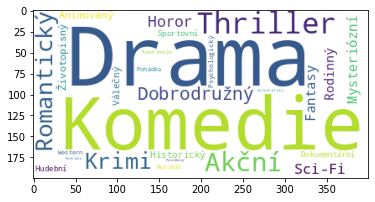

In [222]:
import wordcloud
import matplotlib.pyplot as plt 

item_count_list_genres = analyse_freq(movies['genres'])
genres, genre_counts = [list(t) for t in zip(*item_count_list_genres)]

wc = wordcloud.WordCloud(background_color='white')
wc.generate_from_frequencies(dict(zip(genres, genre_counts)))

plt.imshow(wc)

### LSI

In [223]:
import os.path
from gensim import corpora
from gensim.models import LsiModel
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from gensim.models.coherencemodel import CoherenceModel
import matplotlib.pyplot as plt

In [224]:
document_list = movie_db.description.to_list()
titles = movie_db.title.to_list()

In [225]:
docs_preprocessed = list(tqdm(map(GensimModelWrapper._document_to_tokens, documents), desc='Processing', total=len(documents)))


Processing:  77%|███████████████████████████████████████████████████████████▏                 | 6663/8674 [00:12<00:04, 483.17it/s]


Processing: 100%|█████████████████████████████████████████████████████████████████████████████| 8674/8674 [00:16<00:00, 513.01it/s]


In [226]:
docs_preprocessed

[['mal',
  'belgick',
  'detektiv',
  'hercul',
  'poirot',
  'david',
  'suchet',
  'knírk',
  'upraven',
  'dle',
  'pravítk',
  'neuvěřiteln',
  'bystr',
  'šed',
  'kůr',
  'mozk',
  'řeš',
  'případ',
  'slavn',
  'britsk',
  'polici',
  'ani',
  'scotland',
  'yard',
  'již',
  'rok',
  '1989',
  'dod',
  'tét',
  'nejslavnějš',
  'voln',
  'inspirovan',
  'adaptak',
  'předloh',
  'královn',
  'detektivek',
  'agath',
  'christi'],
 ['televizn',
  'obrazovk',
  'vrac',
  'cykl',
  'lid',
  'postižen',
  'zlok',
  'vzrůstajíc',
  'zločinnost',
  'stál',
  'častějš',
  'osobn',
  'zkušenost',
  'každ',
  'oloupen',
  'vykraden',
  'napaden',
  'nemohouc',
  'spravedlnost',
  'někd',
  'nepochopiteln',
  'důvod',
  'nahráv',
  'spíš',
  'zločink',
  'obět',
  'vedl',
  'scenárist',
  'miroslav',
  'sovják',
  'režisér',
  'petr',
  'slavík',
  'vytvořen',
  'tét',
  'séri',
  'česk',
  'televih'],
 ['mal',
  'belgick',
  'detektiv',
  'hercul',
  'poirot',
  'david',
  'suchet',
  

### Additional Stopwords (stems)
Too many to manually process, our Czech preprocessing is shit
**examples:**   
jak, abym, film?, však, kter, tak, svo, tom, svéh, měl, čím, the, zda, někd, ...


In [227]:
a = analyse_freq(docs_preprocessed)

[('jak', 4148),
 ('aby', 4108),
 ('film', 3916),
 ('život', 3879),
 ('však', 3652),
 ('své', 2658),
 ('svět', 2423),
 ('kter', 2294),
 ('let', 2031),
 ('příběh', 1891),
 ('nov', 1882),
 ('tak', 1870),
 ('žen', 1841),
 ('rok', 1835),
 ('svo', 1744),
 ('tom', 1721),
 ('cest', 1691),
 ('mlad', 1662),
 ('svéh', 1626),
 ('rodin', 1577),
 ('lid', 1542),
 ('cel', 1538),
 ('dom', 1521),
 ('rozhodn', 1490),
 ('práv', 1455),
 ('při', 1449),
 ('dalš', 1357),
 ('začn', 1355),
 ('míst', 1306),
 ('jim', 1297),
 ('lásk', 1290),
 ('dívk', 1182),
 ('mal', 1180),
 ('dob', 1176),
 ('režisér', 1171),
 ('muh', 1163),
 ('velk', 1151),
 ('prvn', 1129),
 ('snaž', 1126),
 ('jedin', 1122),
 ('ani', 1116),
 ('jednoh', 1112),
 ('hlavn', 1104),
 ('druh', 1094),
 ('matk', 1090),
 ('smrt', 1090),
 ('rol', 1068),
 ('nikd', 1062),
 ('syn', 1057),
 ('měst', 1057),
 ('každ', 1053),
 ('svým', 1050),
 ('čas', 1038),
 ('americk', 1035),
 ('jej', 1035),
 ('jedn', 1006),
 ('dcer', 991),
 ('vlastn', 987),
 ('společn', 969),
 

In [236]:
a[::-1]

[('neytir', 1),
 ('pandořan', 1),
 ('přihlásil.průzkumná', 1),
 ('fluorescentn', 1),
 ('vegetac', 1),
 ('nejzranitelnějš', 1),
 ('nesah', 1),
 ('maf', 1),
 ('binár', 1),
 ('koncentrak', 1),
 ('milášk', 1),
 ('život…gluma', 1),
 ('brittl', 1),
 ('schultz', 1),
 ('1858', 1),
 ('svobodu…', 1),
 ('odpykal', 1),
 ('dufresn', 1),
 ('hammersmark', 1),
 ('aldov', 1),
 ('neposkvrně', 1),
 ('sojuz', 1),
 ('neuvážliv', 1),
 ('nalétán', 1),
 ('teleskop', 1),
 ('hubble', 1),
 ('instal', 1),
 ('explorer', 1),
 ('strastiplnějš', 1),
 ('protiváleč', 1),
 ('nejpamátnějš', 1),
 ('shield', 1),
 ('chitaur', 1),
 ('vyoper', 1),
 ('zvýrazněn', 1),
 ('hadovit', 1),
 ('přimích', 1),
 ('válcovit', 1),
 ('lv-223', 1),
 ('nástěnn', 1),
 ('2089', 1),
 ('čistit', 1),
 ('spleten', 1),
 ('extrovertn', 1),
 ('nepohybliv', 1),
 ('teplák', 1),
 ('serióznost', 1),
 ('driss', 1),
 ('hmongsk', 1),
 ('koment', 1),
 ('vejšk', 1),
 ('2030', 1),
 ('masturbuj', 1),
 ('masturboval', 1),
 ('frigidk', 1),
 ('whorw', 1),
 ('nastud

In [243]:
def prepare_corpus(doc_clean):
    """
    Input  : clean document
    Purpose: create term dictionary of our courpus and Converting list of documents (corpus) into Document Term Matrix
    Output : term dictionary and Document Term Matrix
    """
    # Creating the term dictionary of our courpus, where every unique term is assigned an index. dictionary = corpora.Dictionary(doc_clean)
    dictionary = corpora.Dictionary(doc_clean)
    # Converting list of documents (corpus) into Document Term Matrix using dictionary prepared above.
    doc_term_matrix = [dictionary.doc2bow(doc) for doc in doc_clean]
    # generate LDA model
    return dictionary, doc_term_matrix

In [254]:
def create_gensim_lsa_model(doc_clean,number_of_topics,words):
    dictionary, doc_term_matrix = prepare_corpus(doc_clean)
    lsamodel = LsiModel(doc_term_matrix, num_topics=number_of_topics, id2word = dictionary)  # train model
    print(lsamodel.print_topics(num_topics=number_of_topics, num_words=words))
    return lsamodel

In [245]:
def compute_coherence_values(dictionary, doc_term_matrix, doc_clean, stop, start=2, step=3):
    """
    Input   : dictionary : Gensim dictionary
              corpus : Gensim corpus
              texts : List of input texts
              stop : Max num of topics
    purpose : Compute c_v coherence for various number of topics
    Output  : model_list : List of LSA topic models
              coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, stop, step):
        # generate LSA model
        model = LsiModel(doc_term_matrix, num_topics=number_of_topics, id2word = dictionary)  # train model
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=doc_clean, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values

In [246]:
def plot_graph(doc_clean, start, stop, step):
    dictionary,doc_term_matrix = prepare_corpus(doc_clean)
    model_list, coherence_values = compute_coherence_values(dictionary, doc_term_matrix,doc_clean,
                                                            stop, start, step)
    # Show graph
    x = range(start, stop, step)
    plt.plot(x, coherence_values)
    plt.xlabel("Number of Topics")
    plt.ylabel("Coherence score")
    plt.legend(("coherence_values"), loc='best')
    plt.show()

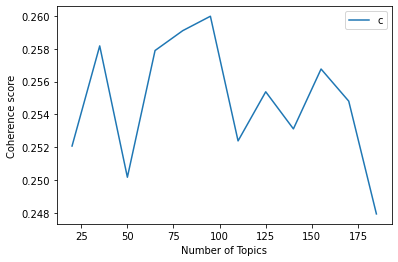

In [249]:
number_of_topics = 100
words = 5

start,stop,step=20,200,15
plot_graph(docs_preprocessed,start,stop,step)
# 110 was optimal

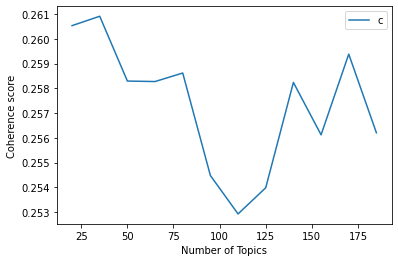

In [248]:
number_of_topics = 100
words = 10

start,stop,step=20,200,15
plot_graph(docs_preprocessed,start,stop,step)
# 110 was optimal

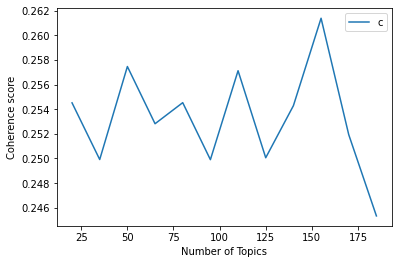

In [250]:
number_of_topics = 100
words = 15

start,stop,step=20,200,15
plot_graph(docs_preprocessed,start,stop,step)
# 110 was optimal

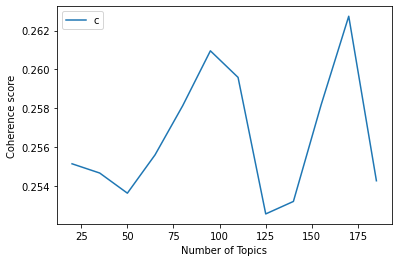

In [251]:
number_of_topics = 100
words = 20

start,stop,step=20,200,15
plot_graph(docs_preprocessed,start,stop,step)
# 110 was optimal

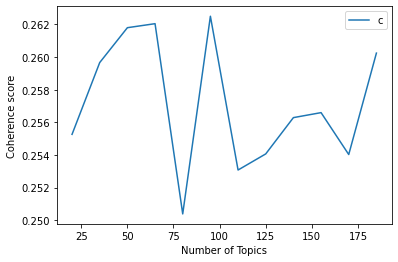

In [252]:
number_of_topics = 100
words = 30

start,stop,step=20,200,15
plot_graph(docs_preprocessed,start,stop,step)
# 110 was optimal

In [255]:
#document_list,titles=load_data("","articles.txt")
#clean_text=preprocess_data(document_list)

#model=create_gensim_lsa_model(docs_preprocessed,number_of_topics,words)
model=create_gensim_lsa_model(docs_preprocessed,number_of_topics=35,words=10)



[(0, '0.256*"jak" + 0.253*"aby" + 0.224*"film" + 0.215*"však" + 0.206*"život" + 0.148*"své" + 0.137*"kter" + 0.123*"tak" + 0.121*"svět" + 0.112*"let"'), (1, '-0.680*"film" + 0.269*"aby" + -0.166*"režisér" + -0.148*"příběh" + 0.148*"však" + -0.132*"rol" + -0.131*"rok" + -0.123*"česk" + 0.095*"dom" + -0.092*"jak"'), (2, '0.450*"život" + 0.434*"ktor" + -0.350*"jak" + 0.235*"však" + 0.171*"ako" + 0.153*"seriál" + 0.137*"svoj" + -0.130*"aby" + 0.126*"všetk" + 0.104*"jej"'), (3, '-0.548*"život" + 0.346*"však" + -0.332*"jak" + 0.245*"aby" + 0.228*"film" + 0.189*"ktor" + -0.104*"rodin" + -0.101*"žen" + -0.098*"svět" + 0.098*"rok"'), (4, '0.731*"jak" + 0.271*"ktor" + -0.210*"život" + -0.204*"film" + -0.175*"aby" + 0.135*"seriál" + 0.107*"ako" + 0.098*"však" + -0.089*"své" + 0.082*"všetk"'), (5, '-0.483*"aby" + 0.460*"však" + 0.255*"svět" + -0.199*"ktor" + -0.186*"tom" + -0.176*"film" + 0.137*"lid" + -0.126*"dom" + -0.123*"matk" + -0.099*"jack"'), (6, '0.445*"svět" + 0.375*"aby" + -0.351*"však" 

In [169]:
'o' in stop_words.get_stop_words('czech')

False